# Etapa 2 — Equalização (HIW / CLAHE) – mini-MIAS (PNG)

Este notebook encadeia **direto após** o notebook de pré-processamento.

Pipeline:
1. Ler imagens **pré-processadas** em `./outputs_preproc/images/*_preproc.png`;
2. Aplicar **HIW** (tests 1–3) **ou CLAHE** (tests 5–6) com os **parâmetros do artigo**;
3. Salvar resultados em `./outputs_eq/<modo>/...` e gerar `manifest_eq_<modo>.csv`;
4. (Opcional) visualizar exemplos e histogramas; (Opcional) calcular métricas MSE/PSNR/SSIM vs original pré-processada.

### Parâmetros dos testes
- **HIW**
  - **test-1**: `n_regions=5` (≈ 4 limiares), `lower_idx=2`
  - **test-2**: `n_regions=4` (≈ 3 limiares), `lower_idx=2`
  - **test-3**: `n_regions=4` (≈ 3 limiares), `lower_idx=1`
- **CLAHE**
  - **test-5**: `kernel_size=(3,3)`, `clip_limit=0.01`, `nbins=256`
  - **test-6** (melhor): `kernel_size=(8,8)`, `clip_limit=0.05`, `nbins=256`


In [1]:
# ==== Configuração de caminhos ====
from pathlib import Path

BASE_DIR = Path('.')
PREPROC_DIR = BASE_DIR / 'outputs_preproc' / 'images'  # entrada
EQ_DIR = BASE_DIR / 'outputs_eq'                       # saída
META_CSV = BASE_DIR / 'outputs_preproc' / 'preprocess_manifest.csv'  # opcional, se quiser carregar metadados

EQ_DIR.mkdir(parents=True, exist_ok=True)
print('PREPROC_DIR =', PREPROC_DIR.resolve())
print('EQ_DIR      =', EQ_DIR.resolve())
print('META_CSV    =', META_CSV.resolve())

PREPROC_DIR = C:\Users\jhter\OneDrive - cefet-rj.br\Processamento-Imagem\Trabalho-1\outputs_preproc\images
EQ_DIR      = C:\Users\jhter\OneDrive - cefet-rj.br\Processamento-Imagem\Trabalho-1\outputs_eq
META_CSV    = C:\Users\jhter\OneDrive - cefet-rj.br\Processamento-Imagem\Trabalho-1\outputs_preproc\preprocess_manifest.csv


In [2]:
# ==== Imports e utilidades ====
import os, glob
import numpy as np
import pandas as pd
import cv2
from skimage import io, util, exposure
from skimage.filters import threshold_multiotsu
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm import tqdm

def read_gray_float01(path: Path):
    img = io.imread(path)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.float32)
    if img.max() > 1.0:
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def save_uint8(image_f32, out_path: Path):
    u8 = np.clip(image_f32, 0, 1)
    u8 = (u8 * 255.0 + 0.5).astype(np.uint8)
    cv2.imwrite(str(out_path), u8)

def plot_hist_before_after(img_raw, img_eq, title=""):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(img_raw.ravel(), bins=256)
    plt.title('Histograma - original')
    plt.subplot(1,2,2)
    plt.hist(img_eq.ravel(), bins=256)
    plt.title('Histograma - equalizada')
    plt.suptitle(title)
    plt.show()


## 2A) HIW — Implementação
Usamos `threshold_multiotsu` para obter limiares das regiões e mapeamos a faixa **[limiar_inferior, 1.0]** para **[0, 1]**, com saturação fora desse intervalo.

In [3]:
def hiw_enhance(img, n_regions=4, lower_idx=2):
    """
    n_regions: nº de regiões para segmentação (ex.: 4 -> ~3 limiares; 5 -> ~4 limiares)
    lower_idx: qual limiar usar como inferior para o mapeamento (1,2,...)
    Mapeia [threshold[lower_idx-1], 1.0] -> [0,1], saturando fora.
    """
    img = util.img_as_float32(img)
    # normalização defensiva pelos percentis para robustez
    p_lo, p_hi = np.percentile(img, (0.5, 99.5))
    if p_hi > p_lo:
        img_n = np.clip((img - p_lo) / (p_hi - p_lo), 0, 1)
    else:
        img_n = img.copy()

    # thresholds do multi-Otsu
    thresholds = threshold_multiotsu(img_n, classes=n_regions)
    lower_idx = max(1, min(lower_idx, len(thresholds)))
    lo = thresholds[lower_idx-1]
    hi = 1.0

    out = np.zeros_like(img_n, dtype=np.float32)
    sel = (img_n >= lo) & (img_n <= hi)
    if sel.any():
        out[sel] = (img_n[sel] - lo) / max(1e-6, (hi - lo))
    out[img_n > hi] = 1.0
    # abaixo de 'lo' fica 0
    return out

# Presets alinhados aos testes do artigo
def hiw_test1(img):  # test-1: 4 limiares -> n_regions=5, lower=2
    return hiw_enhance(img, n_regions=5, lower_idx=2)

def hiw_test2(img):  # test-2: 3 limiares -> n_regions=4, lower=2
    return hiw_enhance(img, n_regions=4, lower_idx=2)

def hiw_test3(img):  # test-3: 3 limiares -> n_regions=4, lower=1
    return hiw_enhance(img, n_regions=4, lower_idx=1)


## 2B) CLAHE — Implementação (parâmetros do artigo)

In [4]:
def clahe_enhance(img, kernel_size=(8,8), clip_limit=0.05, nbins=256):
    img = util.img_as_float32(img)
    return exposure.equalize_adapthist(img, kernel_size=kernel_size, clip_limit=clip_limit, nbins=nbins)

def clahe_test5(img):  # [3x3], clip=0.01
    return clahe_enhance(img, kernel_size=(3,3), clip_limit=0.01, nbins=256)

def clahe_test6(img):  # [8x8], clip=0.05 (melhor global reportado)
    return clahe_enhance(img, kernel_size=(8,8), clip_limit=0.05, nbins=256)


## Execução em lote
Escolha um **modo** e processe todas as imagens pré-processadas. Os resultados irão para `./outputs_eq/<modo>/` com um `manifest_eq_<modo>.csv`.

In [5]:
from datetime import datetime

MODES = {
    'hiw_test1': hiw_test1,
    'hiw_test2': hiw_test2,
    'hiw_test3': hiw_test3,
    'clahe_test5': clahe_test5,
    'clahe_test6': clahe_test6,
}

def run_equalization(mode='clahe_test6', save_histograms=False, compute_metrics=False):
    assert mode in MODES, f"Modo inválido: {mode}"
    fn = MODES[mode]

    in_paths = sorted(glob.glob(str(PREPROC_DIR / '*_preproc.png')))
    assert len(in_paths) > 0, f"Nenhuma imagem pré-processada encontrada em {PREPROC_DIR}"

    out_dir = EQ_DIR / mode
    out_dir.mkdir(parents=True, exist_ok=True)

    logs = []
    for p in tqdm(in_paths, desc=f'Equalizando [{mode}]'):
        img = read_gray_float01(p)
        eq = fn(img)
        out_path = out_dir / (Path(p).stem.replace('_preproc','') + f'_{mode}.png')
        save_uint8(eq, out_path)

        rec = {
            'timestamp': datetime.now().isoformat(timespec='seconds'),
            'input_preproc': p,
            'output_eq': str(out_path),
            'mode': mode,
        }
        if compute_metrics:
            rec['MSE'] = float(mse(img, eq))
            rec['PSNR'] = float(psnr(img, eq, data_range=1.0))
            rec['SSIM'] = float(ssim(img, eq, data_range=1.0))
        logs.append(rec)

        if save_histograms:
            plot_hist_before_after(img, eq, title=os.path.basename(p))

    df = pd.DataFrame(logs)
    df.to_csv(EQ_DIR / f'manifest_eq_{mode}.csv', index=False)
    print(f"Manifest salvo: {EQ_DIR / f'manifest_eq_{mode}.csv'}  |  Saídas: {out_dir}")

print('Modos disponíveis:', list(MODES.keys()))

Modos disponíveis: ['hiw_test1', 'hiw_test2', 'hiw_test3', 'clahe_test5', 'clahe_test6']


### Rodar um único modo (ex.: **CLAHE test-6**)

In [6]:
# Exemplo: CLAHE test-6 (recomendado pelo artigo)
run_equalization('clahe_test6', save_histograms=False, compute_metrics=True)

Equalizando [clahe_test6]: 100%|██████████| 322/322 [02:46<00:00,  1.93it/s]

Manifest salvo: outputs_eq\manifest_eq_clahe_test6.csv  |  Saídas: outputs_eq\clahe_test6


### (Opcional) Rodar todos os modos em sequência

In [ ]:
for m in ['hiw_test1','hiw_test2','hiw_test3','clahe_test5','clahe_test6']:
    run_equalization(m, save_histograms=False, compute_metrics=True)

## Visualização pontual
Escolha uma imagem pré-processada e compare com a versão equalizada (modo à sua escolha).

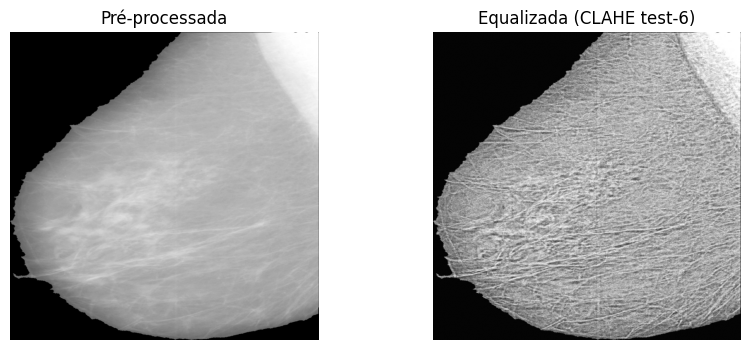

In [10]:
import random
sample_in = sorted(glob.glob(str(PREPROC_DIR / '*_preproc.png')))
if len(sample_in):
    sp = random.choice(sample_in)
    img0 = read_gray_float01(sp)
    eq = clahe_test6(img0)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img0, cmap='gray'); plt.title('Pré-processada'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(eq, cmap='gray'); plt.title('Equalizada (CLAHE test-6)'); plt.axis('off')
    plt.show()
else:
    print('Nenhuma entrada encontrada em PREPROC_DIR. Rode o notebook de pré-processamento primeiro.')